In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
input_path = "../content/DATA_CHAMBER_2021/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -uq "/content/drive/My Drive/DATA_CHAMBER_2021.zip" -d "./"

In [5]:
class ImageFolderWithPaths(datasets.ImageFolder):

    # called by dataloaders
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
preprocess = {
    'train':
    transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(229),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(229),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    'train': 
    ImageFolderWithPaths(input_path + 'train', preprocess['train']),
    'validation': 
    ImageFolderWithPaths(input_path + 'test', preprocess['validation'])
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','validation']}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=2, pin_memory=True)
}

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', pretrained=False)
model.classifier[1] = nn.Conv2d(512, 3, kernel_size=(1,1), stride=(1,1))
# fine tuning

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
import torchvision
from torch.autograd import Variable
import time
from PIL import Image
from torchvision import transforms

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

In [10]:
# t0 = time.time()
# print('{} seconds'.format(time.time() - t0)
epochLine = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [11]:
def train_model(model, criterion, optimizer, num_epochs=1):
    train_batches = len(dataloaders['train'])
    lossLine = []
    accLine = []
    timeLine = []
    for epoch in range(num_epochs):
        print('-' * 40)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 20)
        t0 = time.time()

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            training_loss = 0.0
            training_corrects = 0

            for i,data in enumerate(dataloaders[phase]):
                inputs, labels,_ = data
                print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # loss.requires_grad = True

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                training_loss += loss.item() * inputs.size(0)
                training_corrects += torch.sum(preds == labels.data)

            epoch_loss = training_loss / len(image_datasets[phase])
            lossLine.append(epoch_loss)
            epoch_acc = training_corrects.double() / len(image_datasets[phase])
            accLine.append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            t1 = time.time()
            t = t1 - t0
            print('Duration :{} seconds'.format(t))
            ts = pd.DataFrame([t]).apply(np.float32)
            timeLine.append(ts)
    return model, lossLine, accLine, timeLine

In [12]:
model = model.to(device)
model_trained, lossLine, accLine, timeLine = train_model(model, criterion, optimizer, num_epochs=20)

----------------------------------------
Epoch 1/20
--------------------
Training batch 210/210train loss: 1.0992, acc: 0.3461
Duration :52.34785556793213 seconds
----------------------------------------
Epoch 2/20
--------------------
Training batch 210/210train loss: 1.0978, acc: 0.3508
Duration :52.50255227088928 seconds
----------------------------------------
Epoch 3/20
--------------------
Training batch 210/210train loss: 1.0961, acc: 0.3610
Duration :53.445353269577026 seconds
----------------------------------------
Epoch 4/20
--------------------
Training batch 210/210train loss: 1.0970, acc: 0.3537
Duration :52.81266140937805 seconds
----------------------------------------
Epoch 5/20
--------------------
Training batch 210/210train loss: 1.0968, acc: 0.3586
Duration :52.60710000991821 seconds
----------------------------------------
Epoch 6/20
--------------------
Training batch 210/210train loss: 1.0958, acc: 0.3615
Duration :52.78201103210449 seconds
---------------------

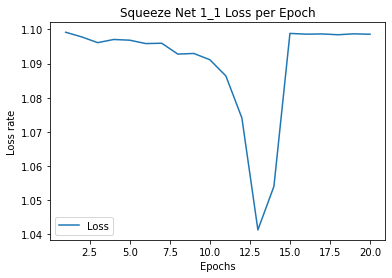

In [13]:
plt.plot(epochLine, lossLine, label="Loss")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss rate")
plt.title("Squeeze Net 1_1 Loss per Epoch")
plt.legend()
plt.show()

In [14]:
print(lossLine)

[1.0991621707474988, 1.097798537654289, 1.0961158448818877, 1.0970425038567004, 1.0968362269913385, 1.0958456361118094, 1.095939597115198, 1.092763156359867, 1.0929443429619212, 1.0911177724213832, 1.0863758277481326, 1.0740679364412407, 1.0412723223545801, 1.0540242349176832, 1.0988191479424094, 1.0985996878464803, 1.0986649189674023, 1.0984299458863924, 1.0986978789605395, 1.098580311252298]


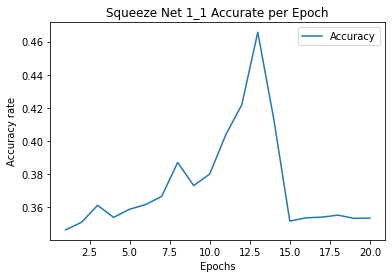

In [15]:
plt.plot(epochLine, accLine, label="Accuracy")
plt.plot()

plt.xlabel("Epochs")
plt.ylabel("Accuracy rate")
plt.title("Squeeze Net 1_1 Accurate per Epoch")
plt.legend()
plt.show()

In [16]:
print(accLine)

[tensor(0.3461, device='cuda:0', dtype=torch.float64), tensor(0.3508, device='cuda:0', dtype=torch.float64), tensor(0.3610, device='cuda:0', dtype=torch.float64), tensor(0.3537, device='cuda:0', dtype=torch.float64), tensor(0.3586, device='cuda:0', dtype=torch.float64), tensor(0.3615, device='cuda:0', dtype=torch.float64), tensor(0.3664, device='cuda:0', dtype=torch.float64), tensor(0.3869, device='cuda:0', dtype=torch.float64), tensor(0.3729, device='cuda:0', dtype=torch.float64), tensor(0.3799, device='cuda:0', dtype=torch.float64), tensor(0.4036, device='cuda:0', dtype=torch.float64), tensor(0.4218, device='cuda:0', dtype=torch.float64), tensor(0.4657, device='cuda:0', dtype=torch.float64), tensor(0.4131, device='cuda:0', dtype=torch.float64), tensor(0.3515, device='cuda:0', dtype=torch.float64), tensor(0.3534, device='cuda:0', dtype=torch.float64), tensor(0.3539, device='cuda:0', dtype=torch.float64), tensor(0.3551, device='cuda:0', dtype=torch.float64), tensor(0.3531, device='cuda

In [17]:
total_time_train = 0
for i in timeLine:  total_time_train += i
print(total_time_train)

             0
0  1053.888062


In [18]:
def test_model(model, criterion, optimizer):
    labels_input=list()
    labels_output=list()
    vid_id = list()
    for phase in ['validation']:
        model.eval()

        for inputs, labels, fname in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_input= labels_input + labels.tolist()
            for f in fname:
                vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            labels_output= labels_output + preds.tolist()
    return labels_input,labels_output,vid_id
            
y_true,y_pred,vid_id = test_model(model, criterion, optimizer)

In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
print(classification_report(y_true,y_pred))
accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.25      1.00      0.41       409
           1       0.00      0.00      0.00       367
           2       0.00      0.00      0.00       831

    accuracy                           0.25      1607
   macro avg       0.08      0.33      0.14      1607
weighted avg       0.06      0.25      0.10      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.2545115121344119

In [20]:
df = pd.DataFrame(list(zip(y_true,y_pred,vid_id)),
               columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [21]:
vid_list = list(set(df['vid_id'].values))

y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

vid: 173 label: 2 pred: 0
vid: 185 label: 1 pred: 0
vid: 178 label: 0 pred: 0
vid: 167 label: 2 pred: 0
vid: 183 label: 0 pred: 0
vid: 184 label: 2 pred: 0
vid: 164 label: 2 pred: 0
vid: 182 label: 2 pred: 0
vid: 174 label: 1 pred: 0
vid: 176 label: 0 pred: 0
vid: 191 label: 0 pred: 0
vid: 190 label: 1 pred: 0
vid: 195 label: 2 pred: 0
vid: 166 label: 1 pred: 0
vid: 187 label: 2 pred: 0
vid: 172 label: 2 pred: 0
vid: 170 label: 2 pred: 0
vid: 194 label: 1 pred: 0
vid: 177 label: 0 pred: 0
vid: 158 label: 0 pred: 0
vid: 181 label: 0 pred: 0
vid: 160 label: 2 pred: 0
vid: 175 label: 1 pred: 0
vid: 169 label: 0 pred: 0
vid: 186 label: 1 pred: 0
vid: 189 label: 1 pred: 0
vid: 193 label: 2 pred: 0
vid: 162 label: 1 pred: 0
vid: 165 label: 0 pred: 0
vid: 157 label: 1 pred: 0
vid: 192 label: 0 pred: 0
vid: 163 label: 2 pred: 0
vid: 171 label: 0 pred: 0
vid: 179 label: 1 pred: 0
vid: 180 label: 2 pred: 0
vid: 188 label: 2 pred: 0
vid: 168 label: 0 pred: 0
vid: 159 label: 1 pred: 0
vid: 161 lab

In [22]:
accuracy_score(y_true,y_pred)

0.3076923076923077